In [1]:
import pandas as pd
from pyspark.sql import SparkSession

TODO:
- Fix schema to be proper

In [2]:
spark = SparkSession.builder.appName("EDA Vehicle").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
24/06/13 10:19:26 WARN Utils: Your hostname, DevanshNZ resolves to a loopback address: 127.0.1.1; using 172.17.62.21 instead (on interface eth0)
24/06/13 10:19:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/13 10:19:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# ** Convert xlsx file to csv **

# Read excel file in pandas:
# geo_vehicle_dist_path = "../local_datasets/aaa_data/geographic_vehicle_distribution.xlsx"
# df_temp = pd.read_excel(geo_vehicle_dist_path, sheet_name="Registration Numbers")

# Convert pandas dataframe to csv file:

out_file_path = "../local_datasets/aaa_data/geographic_vehicle_distribution.csv"
# df_temp.to_csv(out_file_path, index=False)

In [4]:
# Read csv file into spark dataframe:
geo_vehicle_dist_path = out_file_path

df = spark.read.csv(geo_vehicle_dist_path, header=True, inferSchema=True)
df.show()

+--------+-----+-----------+-----------------------------------+-----------------------------------+-----------------------------------+
|Postcode|State|  Fuel Type|Registrations as at 31 January 2021|Registrations as at 31 January 2022|Registrations as at 31 January 2023|
+--------+-----+-----------+-----------------------------------+-----------------------------------+-----------------------------------+
|     800|   NT|        ICE|                               6780|                               7318|                               7089|
|     800|   NT|        BEV|                                  3|                                  3|                                 12|
|     800|   NT|      HFCEV|                                  0|                                  0|                                  0|
|     800|   NT|Hybrid/PHEV|                                131|                                411|                                402|
|     810|   NT|        ICE|             

In [5]:
df.describe()

DataFrame[summary: string, Postcode: string, State: string, Fuel Type: string, Registrations as at 31 January 2021: string, Registrations as at 31 January 2022: string, Registrations as at 31 January 2023: string]

In [6]:
# Read postcode data and load into python dictionary:
# Update postcode csv with : https://www.matthewproctor.com/australian_postcodes
postcode_path = "../local_datasets/postcode_data/australian_postcodes_matthew_proctor.csv"
postcode_df = pd.read_csv(postcode_path)
postcode_df.head()

,id,postcode,locality,state,long,lat,dc,type,status,sa3,...,altitude,chargezone,phn_code,phn_name,lgaregion,lgacode,electorate,electoraterating,sed_code,sed_name
0,230,200,ANU,ACT,149.11900,-35.277700,NaN,NaN,Updated 3-Dec-2022,NaN,...,NaN,N2,NaN,NaN,Unincorporated ACT,89399.0,Durack,NaN,NaN,NaN
1,21820,200,Australian National University,ACT,149.11890,-35.277700,NaN,NaN,Updated 3-Dec-2022,NaN,...,NaN,N2,NaN,NaN,Unincorporated ACT,89399.0,Durack,NaN,NaN,NaN
2,232,800,DARWIN,NT,130.83668,-12.458684,NaN,NaN,Updated 3-Dec-2022,70101.0,...,NaN,NT1,PHN701,Northern Territory,Darwin Waterfront Precinct,71150.0,Solomon,Inner Metropolitan,70022.0,Port Darwin
3,24049,800,DARWIN CITY,NT,130.83668,-12.458684,NaN,NaN,Updated 3-Dec-2022,70101.0,...,NaN,NT1,PHN701,Northern Territory,Darwin Waterfront Precinct,71150.0,Solomon,Inner Metropolitan,70022.0,Port Darwin
4,233,801,DARWIN,NT,130.83668,-12.458684,NaN,NaN,Updated 3-Dec-2022,70101.0,...,NaN,NT1,PHN701,NaN,Darwin,71000.0,Lingiari,Rural,NaN,NaN


In [7]:
postcode_dict = {}
for _, row in postcode_df.iterrows():
    postcode_num = int(row["postcode"])
    lat = float(row["lat"])
    long = float(row["long"])
    
    # Add to the postcode dict
    postcode_dict[postcode_num] = (lat, long)

In [8]:
postcode_dict[800]

(-12.458684, 130.83668)

In [9]:
lats_found = []
longs_found = []
for i in df.select("Postcode").rdd.toLocalIterator():
    t = postcode_dict[int(i[0])]
    lats_found.append(t[0])
    longs_found.append(t[1])


In [10]:
# Create lat long location dataframe:
# TODO: Add this to the geographic dataframe that already exists!
df_vehicle_registration_locations = pd.DataFrame({
    "Latitude": lats_found,
    "Longitude": longs_found
})

In [11]:
vehicle_df = pd.read_csv(out_file_path)
vehicle_df.head()

,Postcode,State,Fuel Type,Registrations as at 31 January 2021,Registrations as at 31 January 2022,Registrations as at 31 January 2023
0,800,NT,ICE,6780,7318,7089
1,800,NT,BEV,3,3,12
2,800,NT,HFCEV,0,0,0
3,800,NT,Hybrid/PHEV,131,411,402
4,810,NT,ICE,21870,22092,21890


In [12]:
# Insert the data into df:
vehicle_df.insert(1, "Longitude", longs_found, True)
vehicle_df.insert(1, "Latitude", lats_found, True)

In [13]:
vehicle_df.head()

,Postcode,Latitude,Longitude,State,Fuel Type,Registrations as at 31 January 2021,Registrations as at 31 January 2022,Registrations as at 31 January 2023
0,800,-12.458684,130.836680,NT,ICE,6780,7318,7089
1,800,-12.458684,130.836680,NT,BEV,3,3,12
2,800,-12.458684,130.836680,NT,HFCEV,0,0,0
3,800,-12.458684,130.836680,NT,Hybrid/PHEV,131,411,402
4,810,-12.381806,130.866242,NT,ICE,21870,22092,21890


In [16]:
save_file_path = '../cleaned_data/aaa_geographic_vehicle_distribution_lats_longs.csv'
vehicle_df.to_csv(save_file_path)
print(f"Saved dataframe to: {save_file_path}")

Saved dataframe to: ../cleaned_data/aaa_geographic_vehicle_distribution_lats_longs.csv


/tmp/ipykernel_146133/2415306876.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


<Axes: >

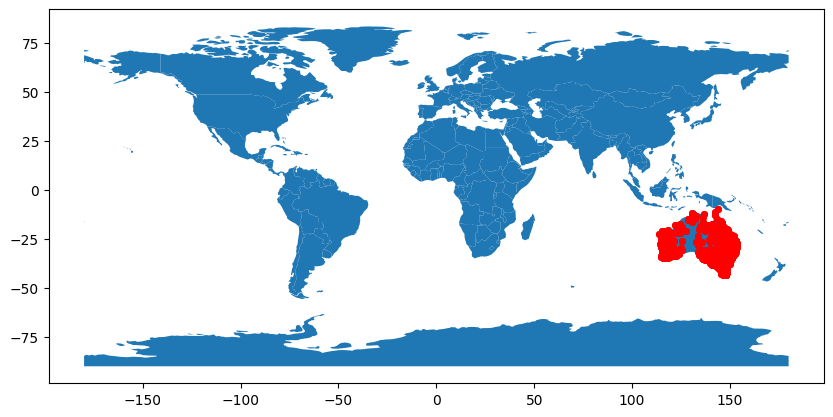

In [42]:
# ** Attempting to plot lat and longs **
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame




geometry = [Point(xy) for xy in zip(df_vehicle_registration_locations['Longitude'], df_vehicle_registration_locations['Latitude'])]
gdf = GeoDataFrame(df_vehicle_registration_locations, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)

In [20]:
# ** Trying with plotly instead ** 
import plotly.express as px

fig = px.scatter_mapbox(df_vehicle_registration_locations,
                        lon = df_vehicle_registration_locations["Longitude"],
                        lat = df_vehicle_registration_locations["Latitude"],
                        zoom = 3,
                        title = 'First Plotly Test')

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0, "t":50, "l":0, "b":10}) # Set margin of plot (right, top, left, bottom)

fig.show()